# Changelog

## Version 3

* Use KFold
* Use Torch TabNet

## Version 1

* Initial Code

# Library

In [1]:
!pip install pytorch-tabnet torch_optimizer

     |████████████████████████████████| 40 kB 405 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import random
import platform
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import torch_optimizer
import pytorch_tabnet
import scipy

In [3]:
!pip freeze > requirements.txt

In [4]:
print('Python version:', platform.python_version())
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Matplotlib version:', matplotlib.__version__)
print('Seaborn version:', sns.__version__)
print('Scikit-Learn version:', sklearn.__version__)
# print('PyTorch TabNet version:', pytorch_tabnet.__version__)
print('PyTorch version:', torch.__version__)
print('PyTorch optimizer version:', torch_optimizer.__version__)
print('Scipy version:', scipy.__version__)

Python version: 3.7.6
Numpy version: 1.18.5
Pandas version: 1.0.3
Matplotlib version: 3.2.1
Seaborn version: 0.10.0
Scikit-Learn version: 0.23.1
PyTorch version: 1.5.0
PyTorch optimizer version: 0.0.1a14
Scipy version: 1.4.1


In [5]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Processed Dataset

In [6]:
df_train = pd.read_parquet('/kaggle/input/shopee-marketing-data/train_processed.parquet')
df_train

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,...,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain
0,4,2019-07-16 00:00:00+08:00,44,19.0,6.0,18.0,0,2,4,12,...,99,0,5,10,0,1.0,1.0,2.0,47.0,0.0
1,4,2019-07-16 00:00:00+08:00,44,9.0,4.0,8.0,2,9,17,18,...,90,1,1,4,1,1.0,1.0,2.0,25.0,3.0
2,6,2019-07-16 00:00:00+08:00,49,14.0,5.0,5.0,0,4,12,24,...,119,5,19,27,0,NaN,1.0,0.0,NaN,2.0
3,1,2019-07-16 00:00:00+08:00,49,49.0,9.0,53.0,0,0,1,9,...,69,1,3,6,0,1.0,1.0,2.0,24.0,2.0
4,6,2019-07-16 00:00:00+08:00,49,227.0,6.0,221.0,0,0,0,2,...,5,0,0,0,0,NaN,1.0,0.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73534,6,2019-09-02 00:00:00+08:00,39,24.0,36.0,279.0,0,1,1,0,...,0,0,0,0,0,1.0,1.0,1.0,37.0,0.0
73535,2,2019-09-02 00:00:00+08:00,38,46.0,10.0,51.0,0,0,1,0,...,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
73536,2,2019-09-02 00:00:00+08:00,32,NaN,NaN,NaN,0,0,0,0,...,0,0,0,0,0,NaN,1.0,0.0,NaN,9.0
73537,2,2019-09-02 00:00:00+08:00,38,5.0,34.0,NaN,2,4,4,0,...,0,0,0,0,1,NaN,1.0,0.0,NaN,0.0


In [7]:
df_test = pd.read_parquet('/kaggle/input/shopee-marketing-data/test_processed.parquet')
df_test

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_1,attr_2,attr_3,age,domain
0,6,2019-09-03 00:00:00+08:00,35,27.0,2.0,13.0,2,3,4,10,34,134,0,6,18,NaN,1.0,0.0,NaN,0.0
1,6,2019-09-03 00:00:00+08:00,35,7.0,5.0,383.0,1,1,1,5,5,5,0,0,0,NaN,1.0,0.0,NaN,0.0
2,5,2019-09-03 00:00:00+08:00,25,34.0,1.0,3.0,0,0,0,13,19,38,2,2,2,1.0,1.0,2.0,33.0,0.0
3,1,2019-09-03 00:00:00+08:00,36,63.0,5.0,5.0,0,0,0,43,110,173,2,5,5,1.0,1.0,2.0,22.0,2.0
4,5,2019-09-03 00:00:00+08:00,23,6.0,5.0,54.0,0,0,0,4,12,39,0,0,2,NaN,1.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,53,NaN,4.0,8.0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,3.0
55966,6,2019-09-29 00:00:00+08:00,53,59.0,802.0,1207.0,0,0,1,0,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
55967,6,2019-09-29 00:00:00+08:00,43,NaN,7.0,NaN,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
55968,6,2019-09-29 00:00:00+08:00,43,5.0,5.0,6.0,2,5,14,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


# Preprocess

## 1. Date

In [8]:
df_train['day'] = pd.to_datetime(df_train['grass_date']).dt.dayofweek.astype('category').cat.codes
df_test['day'] = pd.to_datetime(df_test['grass_date']).dt.dayofweek.astype('category').cat.codes

del df_train['grass_date']
del df_test['grass_date']

In [9]:
# domain
# 1 -> 'other' domain from previous preprocessing
# df_train['domain_nan'] = df_train['domain'].isnull()
df_train['domain'] = df_train['domain'].fillna(1)

# df_test['domain_nan'] = df_test['domain'].isnull()
df_test['domain'] = df_test['domain'].fillna(1)

## 2. Age

In [10]:
def fix_age(age):
    if age < 18 or age >= 100:
        return np.nan
    else:
        return age
    
df_train['age'] = df_train['age'].apply(fix_age)
df_test['age'] = df_test['age'].apply(fix_age)

## 3. NaN

In [11]:
# # last_open_day
NAN_DEFAULT_INT = -9999
# df_train['last_open_day_nan'] = df_train['last_open_day'].isnull()
df_train['last_open_day'] = df_train['last_open_day'].fillna(NAN_DEFAULT_INT)

# df_test['last_open_day_nan'] = df_test['last_open_day'].isnull()
df_test['last_open_day'] = df_test['last_open_day'].fillna(NAN_DEFAULT_INT)

# # last_login_day
# df_train['last_login_day_nan'] = df_train['last_login_day'].isnull()
df_train['last_login_day'] = df_train['last_login_day'].fillna(NAN_DEFAULT_INT)

# df_test['last_login_day_nan'] = df_test['last_login_day'].isnull()
df_test['last_login_day'] = df_test['last_login_day'].fillna(NAN_DEFAULT_INT)

# # last_checkout_day
# df_train['last_checkout_day_nan'] = df_train['last_checkout_day'].isnull()
df_train['last_checkout_day'] = df_train['last_checkout_day'].fillna(NAN_DEFAULT_INT)

# df_test['last_checkout_day_nan'] = df_test['last_checkout_day'].isnull()
df_test['last_checkout_day'] = df_test['last_checkout_day'].fillna(NAN_DEFAULT_INT)

# # attr_1
# df_train['attr_1_nan'] = df_train['attr_1'].isnull()
df_train['attr_1'] = df_train['attr_1'].fillna(NAN_DEFAULT_INT)

# df_test['attr_1_nan'] = df_test['attr_1'].isnull()
df_test['attr_1'] = df_test['attr_1'].fillna(NAN_DEFAULT_INT)

# # attr_2
# df_train['attr_2_nan'] = df_train['attr_2'].isnull()
df_train['attr_2'] = df_train['attr_2'].fillna(NAN_DEFAULT_INT)

# df_test['attr_2_nan'] = df_test['attr_2'].isnull()
df_test['attr_2'] = df_test['attr_2'].fillna(NAN_DEFAULT_INT)

# # attr_3
# df_train['attr_3_nan'] = df_train['attr_3'].isnull()
df_train['attr_3'] = df_train['attr_3'].fillna(NAN_DEFAULT_INT)

# df_test['attr_3_nan'] = df_test['attr_3'].isnull()
df_test['attr_3'] = df_test['attr_3'].fillna(NAN_DEFAULT_INT)

# # age
# df_train['age_nan'] = df_train['age'].isnull()
df_train['age'] = df_train['age'].fillna(NAN_DEFAULT_INT)

# df_test['age_nan'] = df_test['age'].isnull()
df_test['age'] = df_test['age'].fillna(NAN_DEFAULT_INT)

## 4. Misc

In [12]:
X = df_train.copy()
del X['open_flag']

X_test = df_test.copy()

y = df_train['open_flag'].to_numpy()

In [13]:
cat_feature = [
    'country_code','attr_1', 'attr_2', 'attr_3',
    'domain', 'day'
    #'last_open_day_nan', 'last_login_day_nan',
    #'last_checkout_day_nan', 'attr_1_nan', 'attr_2_nan',
    #'attr_3_nan', 'age_nan', 'domain_nan',
]
cat_feature_idx = [X_test.columns.get_loc(ct) for ct in cat_feature]
cat_feature_idx

[0, 14, 15, 16, 18, 19]

In [14]:
cat_feature_dim = [X_test[c].nunique() + 1 for c in cat_feature]
cat_feature_dim

[8, 4, 4, 7, 12, 8]

# Class Weight

In [15]:
label, label_count = np.unique(y, return_counts=True)
lowest_label_count = np.min(label_count)

list_weight = [lowest_label_count/c for c in label_count]
weight_multiplier = 1 / ((label_count[0] * list_weight[0] + label_count[1] * list_weight[1]) / sum(label_count))
list_weight = [lw * weight_multiplier for lw in list_weight]

dict_weight = {
    label[0]: list_weight[0],
    label[1]: list_weight[1],
}
list_weight_each = [list_weight[0] if i == 0 else list_weight[1] for i in y]
print(dict_weight)
print(list_weight)
print(list_weight_each[:10])

{0: 0.5922635826232625, 1: 3.209628142458101}
[0.5922635826232625, 3.209628142458101]
[0.5922635826232625, 3.209628142458101, 0.5922635826232625, 0.5922635826232625, 0.5922635826232625, 0.5922635826232625, 0.5922635826232625, 0.5922635826232625, 3.209628142458101, 0.5922635826232625]


# Model

In [16]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_score, matthews_corrcoef

def predict(X, mode='best_mean'):
    if mode == 'best_mode':
        pass
    elif mode == 'best_mean':
        pass
    elif mode == 'ensemble_mode':
        y_preds = np.empty((len(models), X.shape[0]))
        for i in range(len(models)):
            y_pred = models[i].predict_proba(X)
            y_preds[i] = np.argmax(y_pred, axis=1)
        y_preds = scipy.stats.mode(y_preds)
        y_preds = y_preds[0]
        y_preds = y_preds.reshape(-1)
    elif mode == 'ensemble_mean':
        y_preds = np.empty((len(models), X.shape[0], 2))
        for i in range(len(models)):
            y_preds[i] = models[i].predict_proba(X)
        y_preds = np.mean(y_preds, axis=0)
        y_preds = np.argmax(y_preds, axis=-1)
    elif mode == 'weighted_ensemble_mean':
        pass
    else:
        raise KeyError("Mode isn't supported")
    
    return y_preds


def metrics(y_true, y_pred):
    print('Weighted F1 Score :', f1_score(y_true, y_pred, average='weighted'))
    print('MCC Score :', matthews_corrcoef(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, [0, 1], [0, 1])

    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
    plt.show()

In [17]:
param_dict = {
    'lr': [3e-3, 3e-2],
    'mask_type': ['entmax', 'sparsemax'],
    'weights': [0, 1, dict_weight],
}
param_key = list(param_dict.keys())
param_item = list(param_dict.values())
param_item



[[0.003, 0.03],
 ['entmax', 'sparsemax'],
 [0, 1, {0: 0.5922635826232625, 1: 3.209628142458101}]]

In [18]:
param_list = list(itertools.product(*param_item))
param_list[:10]

[(0.003, 'entmax', 0),
 (0.003, 'entmax', 1),
 (0.003, 'entmax', {0: 0.5922635826232625, 1: 3.209628142458101}),
 (0.003, 'sparsemax', 0),
 (0.003, 'sparsemax', 1),
 (0.003, 'sparsemax', {0: 0.5922635826232625, 1: 3.209628142458101}),
 (0.03, 'entmax', 0),
 (0.03, 'entmax', 1),
 (0.03, 'entmax', {0: 0.5922635826232625, 1: 3.209628142458101}),
 (0.03, 'sparsemax', 0)]

In [19]:
len(param_list)

12

# Train

In [20]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef

K = 5
models = []

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

In [21]:
for param in param_list:
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.loc[train_idx], X.loc[val_idx]
    #     X_train = X_train.to_numpy()
    #     X_val = X_val.to_numpy()
        X_train = X_train.reset_index(drop=True).to_numpy()
        X_val = X_val.reset_index(drop=True).to_numpy()
        y_train, y_val = y[train_idx], y[val_idx]

        model = TabNetClassifier(
            cat_idxs=cat_feature_idx,
    #         cat_emb_dim=cat_feature_dim,
    #         optimizer_fn=torch_optimizer.RAdam,        
            optimizer_params=dict(lr=param[0]),
    #         scheduler_params={"step_size":3, # how to use learning rate scheduler
    #                          "gamma":0.9},
    #         scheduler_fn=torch.optim.lr_scheduler.StepLR,
            mask_type=param[1] # "sparsemax"
        )
        model.fit(
            X_train, y_train,
            X_val, y_val, 
            drop_last=False,
            patience=3,
            weights=param[2]
        )
        models.append(model)

Device used : cpu
Will train until validation stopping metric hasn't improved in 3 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.67103 |  0.72516 |   7.9       
| 2     | 0.81236 |  0.81368 |   15.7      
| 3     | 0.83072 |  0.83684 |   24.1      
| 4     | 0.83713 |  0.84717 |   31.9      
| 5     | 0.84025 |  0.84768 |   39.7      
| 6     | 0.84391 |  0.84873 |   47.1      
| 7     | 0.84551 |  0.84986 |   55.1      
| 8     | 0.84658 |  0.85205 |   63.0      
| 9     | 0.84716 |  0.85132 |   71.0      
| 10    | 0.85057 |  0.85334 |   79.1      
| 11    | 0.85167 |  0.85361 |   87.1      
| 12    | 0.85166 |  0.85414 |   95.4      
| 13    | 0.85357 |  0.85507 |   103.7     
| 14    | 0.85412 |  0.85555 |   111.2     
| 15    | 0.85412 |  0.85606 |   119.4     
| 16    | 0.85528 |  0.85771 |   127.0     
| 17    | 0.85545 |  0.85756 |   135.1     
| 18    | 0.85654 |  0.85744 |   142.8     
| 19    | 0.85812 |  0.85850 | 

Weighted F1 Score : 0.8475011570163127
MCC Score : 0.4972752649463002
              precision    recall  f1-score   support

           0       0.94      0.85      0.90     49667
           1       0.48      0.73      0.58      9165

    accuracy                           0.83     58832
   macro avg       0.71      0.79      0.74     58832
weighted avg       0.87      0.83      0.85     58832



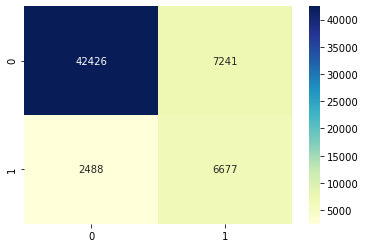

In [22]:
y_train_pred = predict(X_train, mode='ensemble_mode')
metrics(y_train,y_train_pred)

Weighted F1 Score : 0.8475011570163127
MCC Score : 0.4972752649463002
              precision    recall  f1-score   support

           0       0.94      0.85      0.90     49667
           1       0.48      0.73      0.58      9165

    accuracy                           0.83     58832
   macro avg       0.71      0.79      0.74     58832
weighted avg       0.87      0.83      0.85     58832



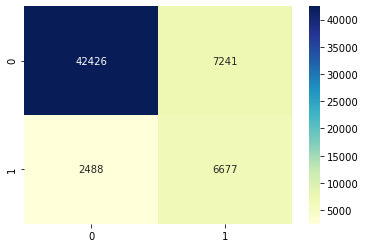

In [23]:
y_train_pred2 = predict(X_train, mode='ensemble_mean')
metrics(y_train,y_train_pred)

In [24]:
y_test_pred = predict(X_test.to_numpy(), mode='ensemble_mode')
y_test_pred = y_test_pred.astype(np.int32)

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred, name='open_flag')], axis=1)
df_submission.to_csv('submission_ensemble_mode.csv', index=False)

df_submission

,row_id,open_flag
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,1


In [25]:
y_test_pred2 = predict(X_test.to_numpy(), mode='ensemble_mean')

df_submission2 = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred2, name='open_flag')], axis=1)
df_submission2.to_csv('submission_ensemble_mean.csv', index=False)

df_submission2

,row_id,open_flag
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,1
